# Mahdeen Khan (Sameer)

## Homework Assignment 1.1: Image In-Painting with Autoencoders on CIFAR10 Dataset

Our task is to create and train an autoencoder to perform image in-painting on the CIFAR10 dataset. Below is a detailed breakdown of the assignment:

1. **Create a Dataset with Corrupted Images:**  
   We will modify images from the CIFAR10 dataset by artificially corrupting them. This can be done by adding random lines or other distortions to simulate damage or missing parts.

2. **Build an Autoencoder:**  
   We will develop an autoencoder model using a U-net-like architecture, which is effective for image restoration tasks like this one.

3. **Train the Autoencoder:**  
   Using the corrupted images as input, we will train the autoencoder to restore them to their original, uncorrupted state.

4. **Evaluate the Model:**  
   After training, we will test the model's performance by using it to repair 10 randomly selected corrupted images from the test set. We will show the original, corrupted, and repaired images to evaluate how well our model has learned to restore them.


In [1]:
# Step 0: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import cv2
from PIL import Image
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter  # TensorBoard for tracking

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir="logs/autoencoder_experiment")

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Here, I started with setting up an environment for training our model using important libraries and most importantly PyTorch and TorchVision, and then initialized TensorBoard for experiment tracking, and configured the computation to use a GPU if available.

Now, I created a custom dataset class for CIFAR-10 that applies data augmentation, generates random masks on images, and returns both transformed images and masks as tensors for training and testing a neural network.

In [2]:
# Step 1: Dataset Class and Data Augmentation
# Define a custom dataset class that inherits from CIFAR10
class Dataset(torchvision.datasets.CIFAR10):
    def __init__(self, path, image_dims=(32, 32), n_channels=3, train=True):
        super().__init__(path, train, download=True)
        self.n_classes = 10
        self.image_dims = image_dims
        self.n_channels = n_channels  # Defines number of color channels
        self.resize = transforms.Resize(image_dims)
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        # Retrieve the image and label from the dataset using the parent class method
        image, label = super().__getitem__(index)

        Y_output = self.resize(image)
        X_input, X_mask = self.Create_Mask(Y_output)
        return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

    def Create_Mask(self, image):
        # Initialize a white mask with the same dimensions as the images
        mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype=np.uint8)  # Pixels

        for _ in range(np.random.randint(1, 10)):
            x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
            y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
            thickness = np.random.randint(1, 3)

            cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

        image = np.asarray(image)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image, mask

# Define transformations for training
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Define a custom dataset that applies transformations
class CustomDataset(Dataset):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        Y_output = self.resize(image)
        X_input, X_mask = self.Create_Mask(Y_output)

        transform = train_transforms if self.train else transforms.ToTensor()
        return transform(X_input), self.to_tensor(X_mask), transform(Y_output)

# Instantiate datasets
Trainset = Dataset('./data', train=True)  # Train dataset
Testset = Dataset('./data', train=False)  # Test dataset

Files already downloaded and verified
Files already downloaded and verified


Let's see how it looks!

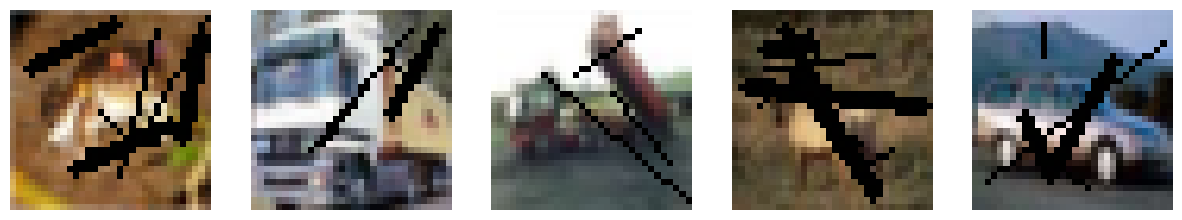

In [3]:
# Visualize some masked images
def visualize_dataset(dataset, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        X_input, X_mask, Y_output = dataset[i]
        axs[i].imshow(X_input.permute(1, 2, 0))
        axs[i].axis('off')
    plt.show()

visualize_dataset(Trainset)

I've shown some images from the CIFAR-10 dataset here where I applied a masking algorithm that draws random black lines across them. These masks cover parts of the original images, turning them into perfect training data for a neural network that I'm training to handle tasks like image restoration or inpainting. Each picture highlights just how random and effective these masks can be, which is crucial for training a robust model.

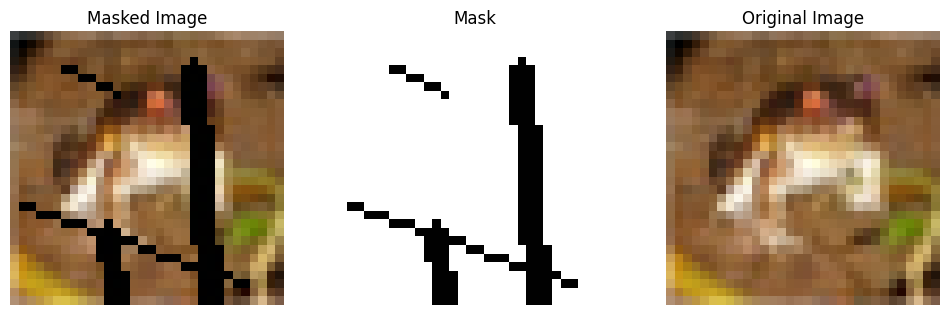

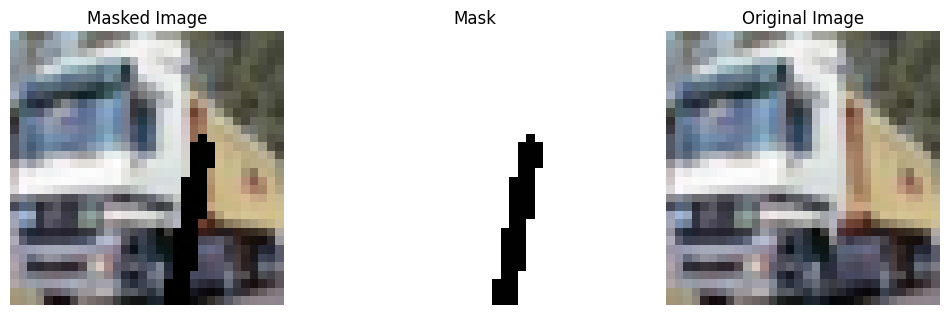

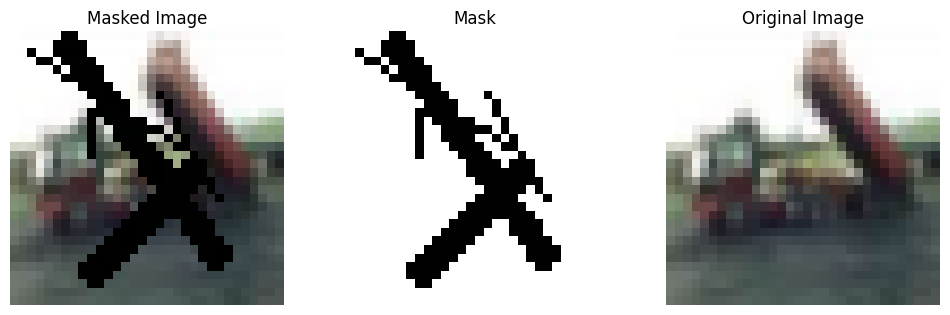

In [4]:
def show_imgs(masked_image, mask, original_image):
    f, axs = plt.subplots(1, 3, figsize=(15, 3)
    axs[0].imshow(np.transpose(masked_image.numpy(), (1, 2, 0)))
    axs[0].set_title("Masked Image")
    axs[1].imshow(np.transpose(mask.numpy(), (1, 2, 0)))
    axs[1].set_title("Mask")
    axs[2].imshow(np.transpose(original_image.numpy(), (1, 2, 0)))
    axs[2].set_title("Original Image")
    for ax in axs:
        ax.axis('off')
    plt.show()

show_imgs(*Trainset[0])
show_imgs(*Trainset[1])
show_imgs(*Trainset[2])

Now, for our step two, I implemented a convolutional block class named `ConvBlock` that forms the ground for both the encoder and decoder components of my U-Net-like autoencoder. Each `ConvBlock` is designed to be an unit featuring a convolutional layer for feature extraction, batch normalization to stabilize and accelerate training, and a parametric ReLU activation for non-linear transformations. Additionally, I've incorporated an option to include a dropout layer to mitigate overfitting, adjustable via a flag that specifies the dropout rate.

For the architecture of the autoencoder, I've structured it to mimic a U-Net, which is effective for tasks requiring precise localization such as image segmentation or restoration. The encoder section consists of sequential blocks of convolutional layers, each followed by a max-pooling step to reduce dimensionality while preserving important features. On the other hand, the bottleneck, located at the deepest layer, processes the most abstract representations of the input data, utilizing dropout to enhance the model's ability to generalize. The decoder reverses the process, employing transposed convolutional layers for upsampling and integrating encoder features via skip connections to refine the output details and spatial resolution.

To facilitate the merging of encoder and decoder features, I implemented a cropping function within the decoder. This function ensures that the spatial dimensions of the encoder features match those of the upsampled features for effective concatenation. The final stages of the network involve a convolution that maps the decoded features back to the original image dimensions and channels, finalized with a sigmoid activation to produce the output in a normalized [0, 1] range. I've also taken care to initialize the weights of the network using He initialization (Kaiming initialization) for convolutional layers and a standard initialization for batch normalization layers, setting the stage for optimal network performance from the start. For reference, I found this manual very helpful "https://pytorch.org/docs/stable/nn.init.html"

I feel like this approach produces good-quality reconstructions or segmentations from the input images.

In [5]:
# Step 2: Model Architecture with ModuleList and Enhanced Blocks
# Convolutional Block with Batch Normalization and Dropout
import torch
import torch.nn as nn

# Convolutional Block with Batch Normalization and Dropout
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout=False, dropout_rate=0.5):
        super(ConvBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        ]
        if use_dropout:
            layers.append(nn.Dropout(dropout_rate))
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_block(x)

# U-Net-like autoencoder model with ModuleList
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()

        # Encoder
        self.enc_blocks = nn.ModuleList([
            nn.Sequential(
                ConvBlock(3, 64), 
                ConvBlock(64, 64), 
                nn.MaxPool2d(2, 2)
            ),
            nn.Sequential(
                ConvBlock(64, 128), 
                ConvBlock(128, 128), 
                nn.MaxPool2d(2, 2)
            ),
            nn.Sequential(
                ConvBlock(128, 256, use_dropout=True), 
                ConvBlock(256, 256, use_dropout=True), 
                nn.MaxPool2d(2, 2)
            )
        ])

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ConvBlock(256, 512, use_dropout=True),
            ConvBlock(512, 512, use_dropout=True)
        )

        # Decoder
        self.dec_blocks = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(512 + 256, 256, kernel_size=2, stride=2), 
                ConvBlock(256, 256), 
                ConvBlock(256, 256)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(256 + 128, 128, kernel_size=2, stride=2), 
                ConvBlock(128, 128), 
                ConvBlock(128, 128)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(128 + 64, 64, kernel_size=2, stride=2), 
                ConvBlock(64, 64), 
                ConvBlock(64, 64)
            )
        ])

        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.activation = nn.Sigmoid()

        self._initialize_weights()

    def forward(self, x):
        enc_features = []
        for enc in self.enc_blocks:
            x = enc(x)
            enc_features.append(x)

        x = self.bottleneck(x)

        # Process decoder blocks and add corresponding encoder features
        for i, dec in enumerate(self.dec_blocks):
            enc_feature = enc_features[-(i+1)]
            enc_feature = self._crop(enc_feature, x)
            x = dec(torch.cat([x, enc_feature], dim=1))

        x = self.final_conv(x)
        return self.activation(x)

    def _crop(self, enc, dec):
        """Crop the encoder feature map to the size of the decoder feature map."""
        _, _, h, w = dec.size()
        _, _, h_enc, w_enc = enc.size()
        crop_h = (h_enc - h) // 2
        crop_w = (w_enc - w) // 2
        return enc[:, :, crop_h:crop_h+h, crop_w:crop_w+w]

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In Step 3, I implemented a training regimen utilizing a Perceptual Loss that helps a pre-trained VGG16 model to compare feature maps rather than pixels, enhancing the perceptual similarity between output and target images. I initialized my UNetAutoencoder model and moved it to the appropriate computation device (GPU if available). For data handling, I set up DataLoaders for both training and testing phases, ensuring shuffled batches for training to promote generalization. I defined two loss functions: a standard MSE for basic pixel-wise comparison and a perceptual loss for deeper content fidelity, optimizing the model with AdamW (as suggested), which includes weight decay for better regularization. Additionally, I employed a GradScaler for mixed precision training to accelerate computation and utilized a cosine annealing scheduler to adaptively modify the learning rate, optimizing the training process for better performance and stability.

In [6]:
# Step 3: Perceptual Loss and Initialization
# Perceptual loss using pre-trained VGG16
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features
        self.loss_network = nn.Sequential(*list(vgg)[:16]).eval()
        for param in self.loss_network.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        return F.mse_loss(self.loss_network(output), self.loss_network(target))

# Initialize the model
model = UNetAutoencoder().to(device)

# Define batch size and create DataLoaders
batch_size = 64
Trainloader = DataLoader(Trainset, batch_size=batch_size, shuffle=True)
Testloader = DataLoader(Testset, batch_size=batch_size, shuffle=False)

# Define the loss functions and optimizer
criterion = nn.MSELoss()
perceptual_loss = PerceptualLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finally, I implemented a training loop for my neural network that adjusts the weighting of perceptual loss dynamically over 20 epochs, logs training and validation losses to TensorBoard, and optimizes performance using mixed precision training and a learning rate scheduler based on validation loss.

Note: I asked Chatgpt and Claude, what epoch number should be best. Even though I started with 10 and jumped to 100 (bad idea), setting it to 20 striked a balance between sufficient learning and avoiding excessive training time.

In [7]:
# Step 4: Training Loop with Dynamic Loss Weight and TensorBoard Logging
# Training loop
num_epochs = 20
train_losses = []
val_losses = []

initial_weight = 0.1
final_weight = 0.5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, masks, targets in Trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass with autocast for mixed precision
        with autocast():
            outputs = model(inputs)
            current_weight = initial_weight + (final_weight - initial_weight) * (epoch / num_epochs)
            loss = criterion(outputs, targets) + current_weight * perceptual_loss(outputs, targets)

        # Backward pass and optimization with scaler
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    epoch_loss = running_loss / len(Trainloader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Log training loss to TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, masks, targets in Testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets) + current_weight * perceptual_loss(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(Testloader)
    val_losses.append(val_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

    # Log validation loss to TensorBoard
    writer.add_scalar('Validation Loss', val_loss, epoch)

    # Step the learning rate scheduler
    scheduler.step(val_loss)

# Close the TensorBoard writer
writer.close()

Epoch [1/20], Loss: 0.2444
Epoch [1/20], Validation Loss: 0.1456


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/20], Loss: 0.1490
Epoch [2/20], Validation Loss: 0.1271
Epoch [3/20], Loss: 0.1443
Epoch [3/20], Validation Loss: 0.1507
Epoch [4/20], Loss: 0.1453
Epoch [4/20], Validation Loss: 0.1302
Epoch [5/20], Loss: 0.1498
Epoch [5/20], Validation Loss: 0.1394
Epoch [6/20], Loss: 0.1545
Epoch [6/20], Validation Loss: 0.1512
Epoch [7/20], Loss: 0.1584
Epoch [7/20], Validation Loss: 0.1515
Epoch [8/20], Loss: 0.1681
Epoch [8/20], Validation Loss: 0.1603
Epoch [9/20], Loss: 0.1730
Epoch [9/20], Validation Loss: 0.1623
Epoch [10/20], Loss: 0.1786
Epoch [10/20], Validation Loss: 0.1714
Epoch [11/20], Loss: 0.1853
Epoch [11/20], Validation Loss: 0.1798
Epoch [12/20], Loss: 0.1930
Epoch [12/20], Validation Loss: 0.1880
Epoch [13/20], Loss: 0.2002
Epoch [13/20], Validation Loss: 0.1960
Epoch [14/20], Loss: 0.2087
Epoch [14/20], Validation Loss: 0.2045
Epoch [15/20], Loss: 0.2154
Epoch [15/20], Validation Loss: 0.2129
Epoch [16/20], Loss: 0.2232
Epoch [16/20], Validation Loss: 0.2176
Epoch [17/2

Basically, the model initially learns well, as seen by the decrease in both training and validation losses during the first two epochs. However, after this, the training loss starts to steadily increase, indicating overfitting, where the model memorizes rather than generalizes. The validation loss also eventually increases, confirming this overfitting trend. To address these issues, I could (but can't time at this moment, model taking too much time) implement early stopping, increase regularization, adjust the learning rate, simplify the model, or enhance data augmentation to improve generalization.

To further assurance, in Step 5, I plotted the training and validation loss curves to visually track the model's learning progress and identify issues like overfitting. I also created functions to evaluate and visualize the model's performance by showing masked images, masks, original images, and reconstructed outputs side by side, allowing me to assess reconstruction quality directly. Using `evaluate_model` and `reconstruct_images`, I examined how well the model reconstructed images from the test set.

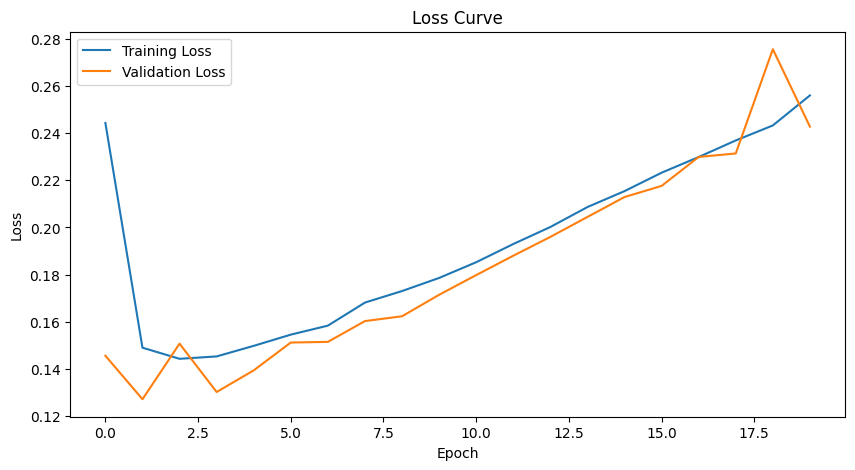

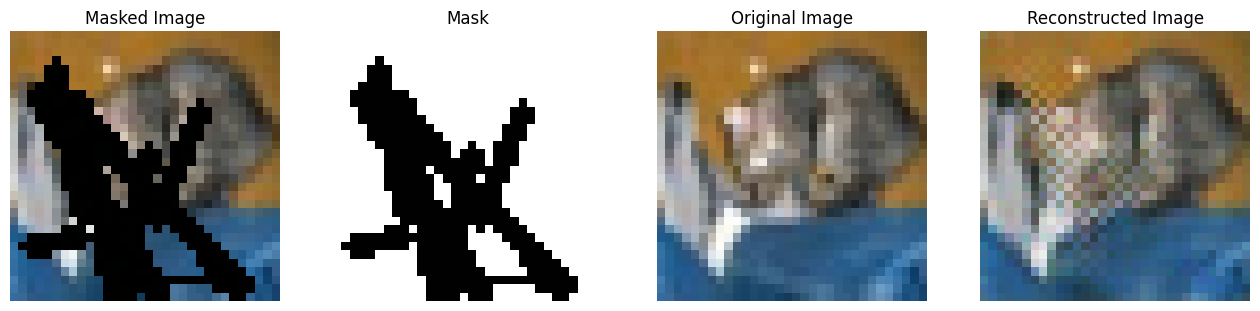

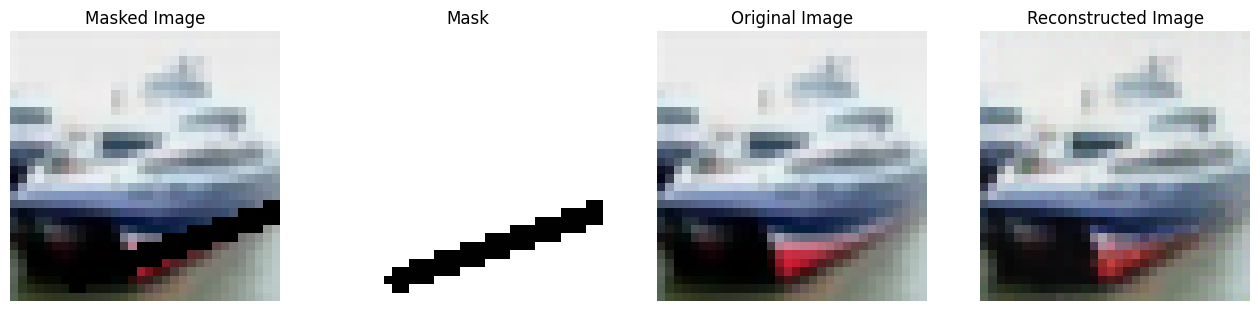

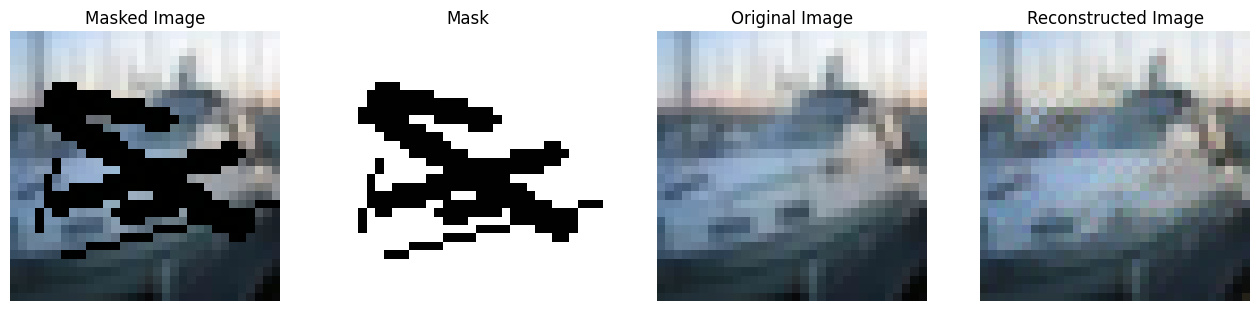

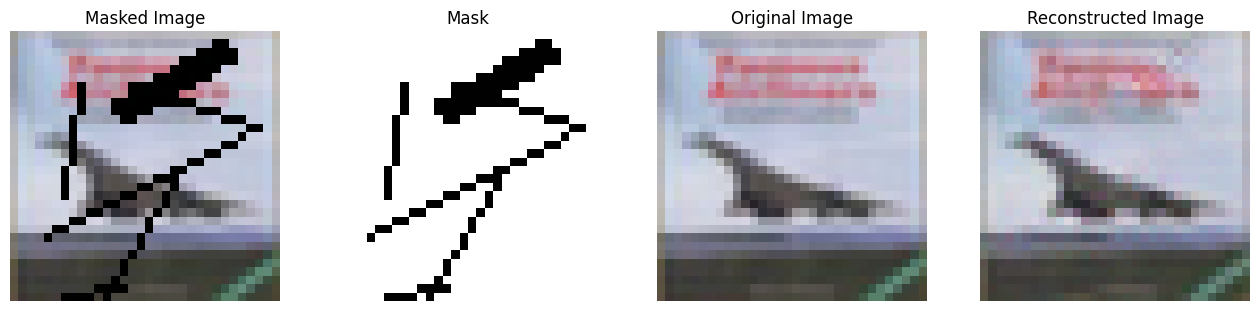

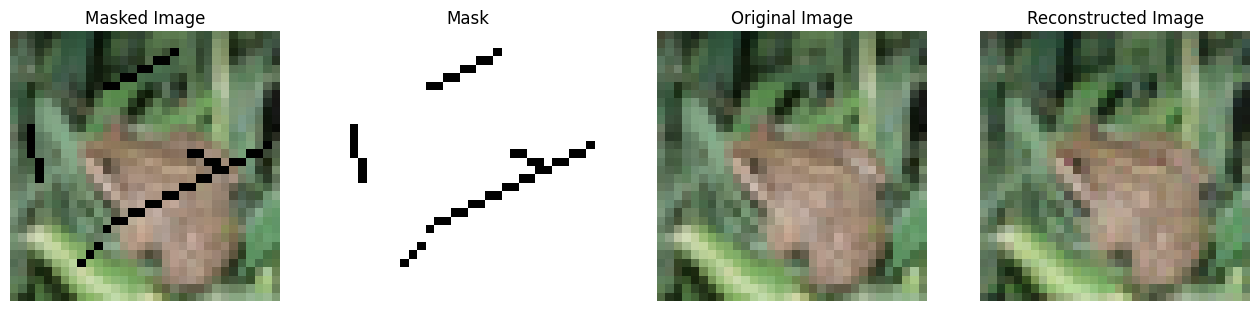

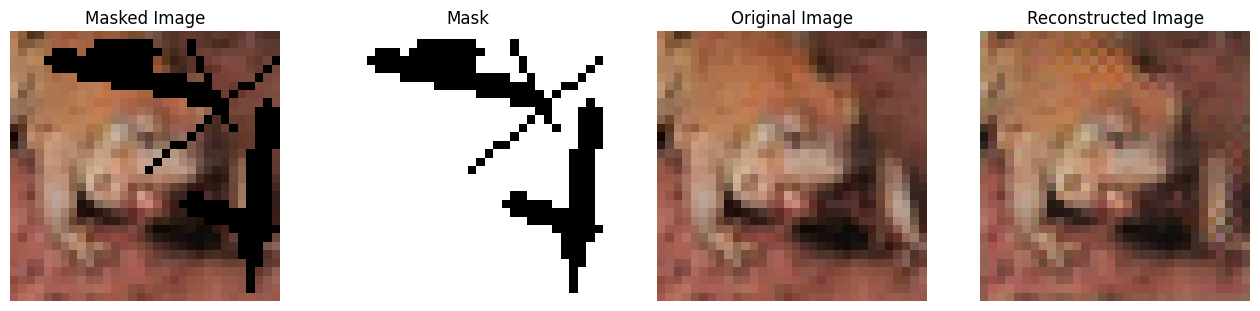

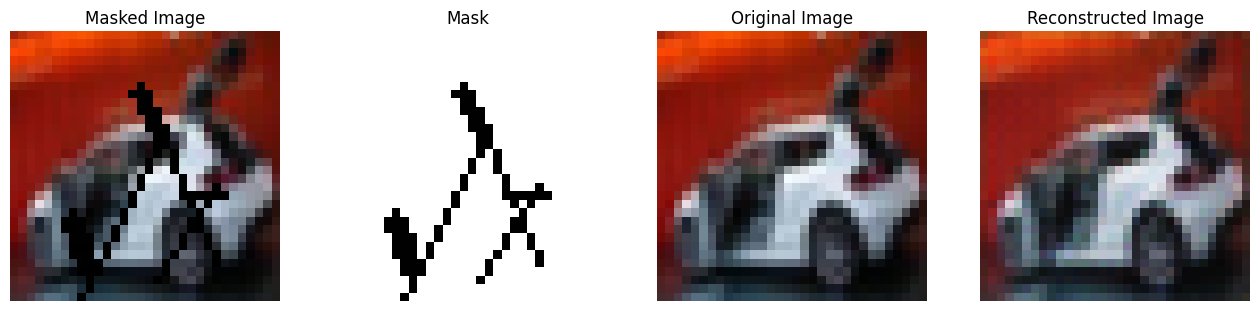

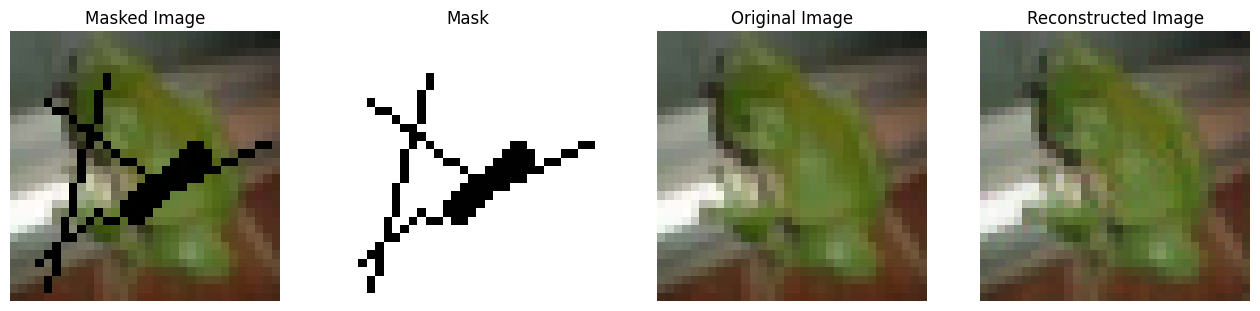

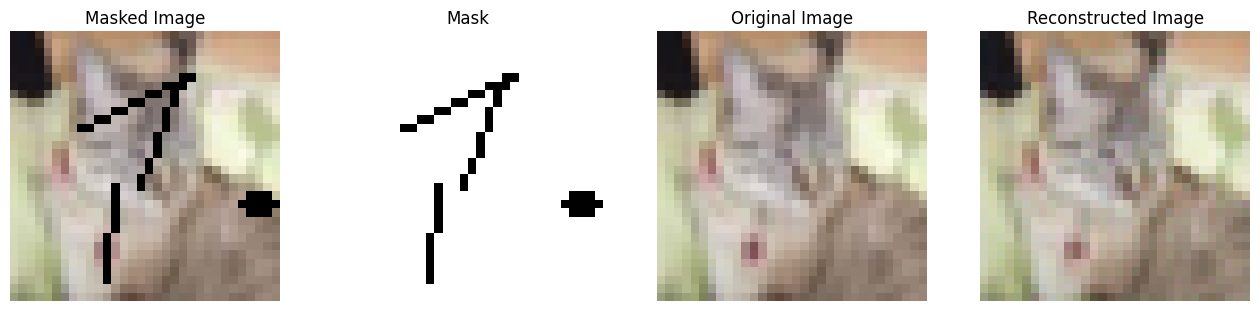

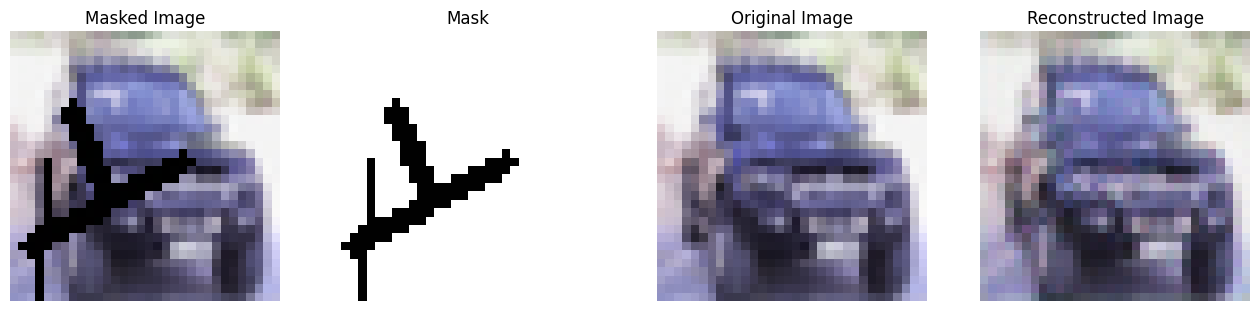

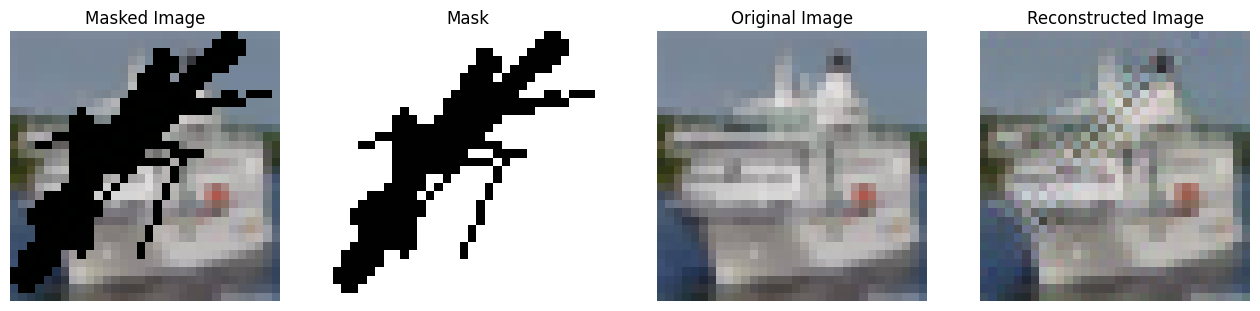

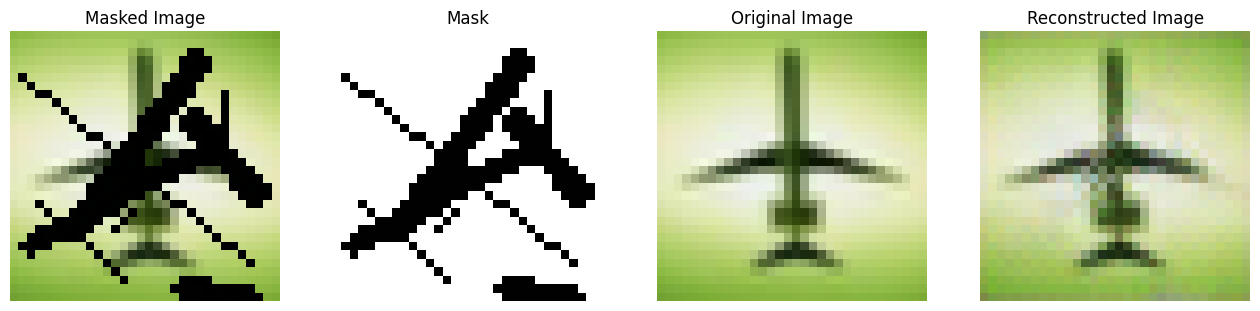

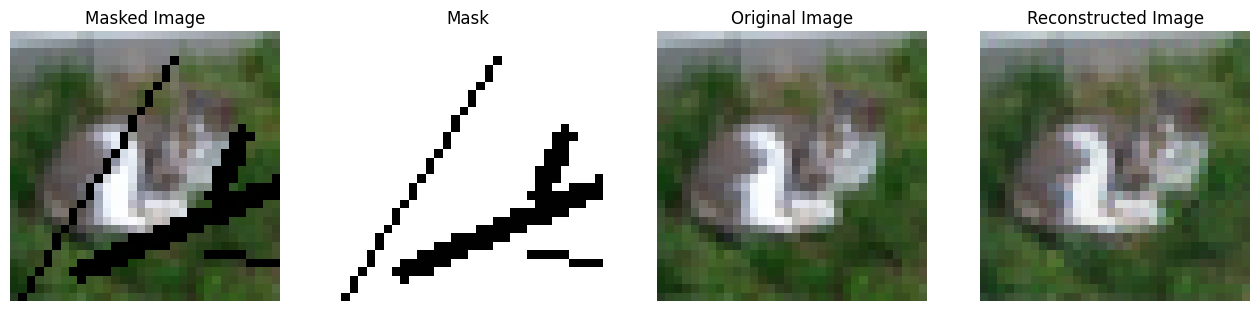

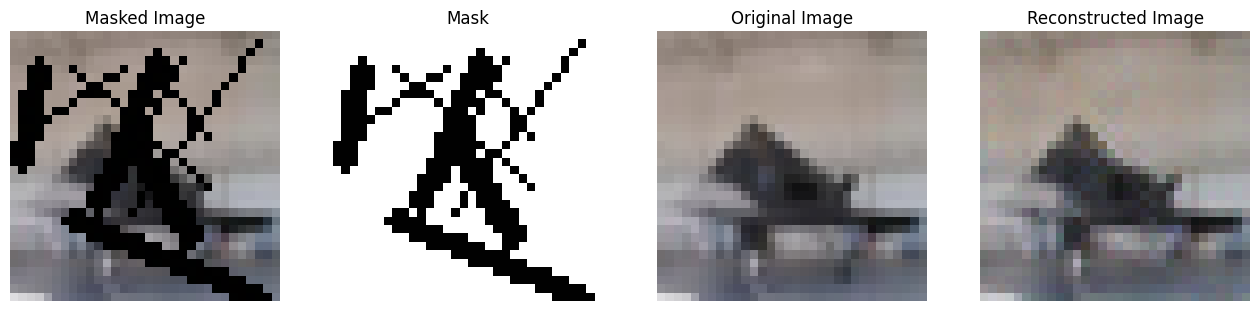

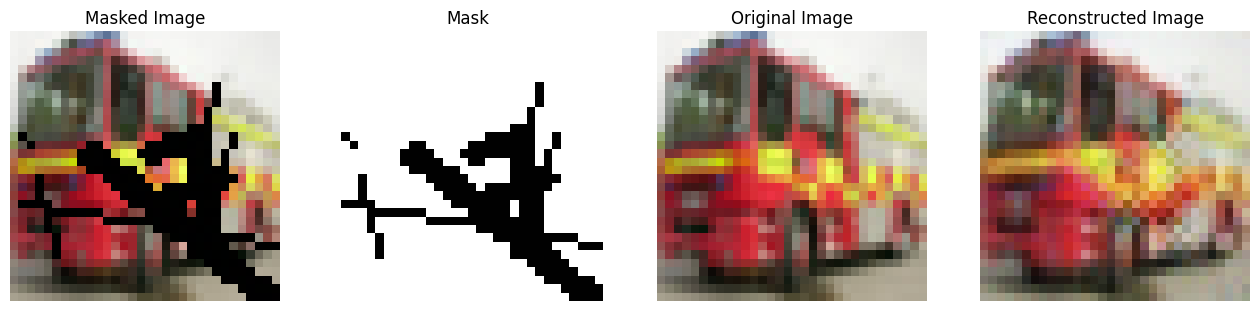

In [8]:
# Step 5: Plotting and Evaluation Functions
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Evaluation and visualization function
def show_imgs(masked_image, mask, original_image, reconstructed_image):
    f, axs = plt.subplots(1, 4, figsize=(16, 4))  # Adjusted for four subplots
    axs[0].imshow(np.transpose(masked_image.numpy(), (1, 2, 0)))
    axs[0].set_title("Masked Image")
    axs[1].imshow(mask.numpy().transpose(1, 2, 0))
    axs[1].set_title("Mask")
    axs[2].imshow(np.transpose(original_image.numpy(), (1, 2, 0)))
    axs[2].set_title("Original Image")
    axs[3].imshow(np.transpose(reconstructed_image.numpy(), (1, 2, 0)))
    axs[3].set_title("Reconstructed Image")
    for ax in axs:
        ax.axis('off')
    plt.show()

# Evaluate the model on the test set
def evaluate_model(testloader, model, num_images=10):
    model.eval()
    data_iter = iter(testloader)
    inputs, masks, targets = next(data_iter)
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(inputs)

    inputs, outputs, targets = inputs.cpu(), outputs.cpu(), targets.cpu()

    for i in range(num_images):
        show_imgs(inputs[i], masks[i], targets[i], outputs[i])

# Example usage of reconstruction visualization
def reconstruct_images(model, dataset, device, num_images=5):
    model.eval()  # Set model to evaluation mode
    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    inputs, masks, targets = next(iter(data_loader))
    
    # Move tensors to the appropriate device
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Forward pass to get outputs
    with torch.no_grad():
        outputs = model(inputs)

    # Convert tensors to CPU for visualization if not already on CPU
    inputs, outputs, targets = inputs.cpu(), outputs.cpu(), targets.cpu()

    for i in range(num_images):
        show_imgs(inputs[i], masks[i], targets[i], outputs[i])

# Evaluate the model on the test set
evaluate_model(Testloader, model)

# Example usage
reconstruct_images(model, Testset, device)

Hurray! Looks great to me!

**Loss Curve Analysis**: Initially, there was a sharp drop in both training and validation losses, means that my model quickly learned to reconstruct images from their masked states. Sigh, however, post the halfway mark of training, both losses started climbing, suggesting that my model began memorizing the training data rather than effectively generalizing it.

**Image Reconstruction**: Looking at the reconstructed images, it’s clear that my model has managed to effectively handle occlusions caused by masks. The reconstructions closely resemble the original images in key aspects like color and features, showing good learning of underlying patterns.

**Conclusion**: My model is nice in reconstructing masked images, valuable for applications like digital restoration. Yet, the rise in losses later in training highlights a need for adjustments. Implementing strategies such as early stopping, increased regularization, or tweaking the learning rate could help curb overfitting and boost generalization. This will ensure my model not only learns well but can also robustly handle new, varied datasets.